## Fundamentals for Social Data Science in Python - Summative
**Willem Zents**
**MT 2020**

# Instructions

The final essay will allow you to consolidate many of the skills you’ve learned in the course thus far in a single report. This report should be submitted as a Jupyter notebook with working code as well as a description of the work you have done. You should also submit a backup PDF of your notebook.

This essay will have two parts. The combined word total should be 3500 words. The structure of the notebook should look as follows: (with the grade weighting for each section):

* Part 1 setup: (500 words/one Jupyter notebook cell) [10 points]
* Part 1 data analysis in Python (any number of Jupyter notebook cells) [20 points]
* Discussion of Part 1 results (one Jupyter notebook cell/750 words) [10 points]
* Part 2 setup of merging in additional data. [10 points]
* Part 2 data analysis in Python (any number of Jupyter notebook cells) [20 points]
* Discussion of Part 2 results: (750 words/one Jupyter notebook cell) [10 points]
* Limitations of these descriptive analyses (one Jupyter notebook cell) [10 points]

There is an additional 10 points for presentation, which includes both the presentation of the code and the presentation of any tabular or graphic data, consistency of bibliographic sources, and correct use of grammar and syntax. Part 1.

# Part 1

The first part will involve the use of the OxCOVID19 database (https://oxcovid19.eng.ox.ac.uk) , which has an extensive set of data not only including COVID-related data but data on world values, geographic mobility, sociodemographic data, and more. Each table can be linked to others using identifiers as discussed on the database website. You should come up with a research question, justify that research question in a literature review section (of less than 750 words), and then proceed to query the database for the relevant data which you should merge, visualise and make claims about. You do not have to include any statistics on COVID-related data itself should you wish not to. You can instead simply use the additional extensive supplementary data. You should be able to plot the merged data in such a way that it speaks to your research question and report on descriptive statistics where relevant. You are asked not to do any complex multivariate modelling. This question should be primarily descriptive in nature. Example research questions include:

Did areas of the world with different social values (as measured by some question on the World Values Survey) have different proportions of COVID infections in April?
Are people in the UK more mobile on days when the weather was above average? Did this hold during lockdown?
Is air pressure more variable in coastal countries (or coastal regions) or inland countries (or inland regions)? You should interpret the resulting output and summarise it in a report section of not more than 750 words.

It is assumed that the evaluators should be able to reproduce your findings by running the Jupyter notebook themselves.

One important caveat is that this work should not require the installation of any external libraries not featured in class.

## Part 1 - Setup
*500 words*

## Introduction
**Research question: Do governments of countries with higher hospital capacity choose to adopt less stringent measures against COVID-19?**

The worldwide spread of the SARS-CoV-2 virus has lead to outbreaks of COVID-19 in many countries that have put a strain on national healthcare systems. In some countries, the demand for healthcare services even exceeded the capacity of hospitals, causing, for instance, patients suffering from long-term illness not to be able to receive necessary treatments. While some countries seemed to be well-prepared to meet the excess demand due to COVID, others seemed to be struggling. One important factor in this regard is the availability of hospital and ICU beds \cite{Bauer2020}. \cite{Bauer2020} find that "geographical access to intensive care beds varies significantly across European countries", and that "low ICU accessibility was associated with a higher proportion of COVID-19 deaths to cases". This conclusion is supported by \cite{Sussman2020}, using a larger and more geographically-spread sample of countries. 

In order to reduce transmission and prevent their medical infrastructure from becoming overwhelmed, many countries adopted strict social-distancing measures such as travel restrictions, school closures, or even complete lockdowns \cite{Davies}. Many of these measures are associated with severe social and economic costs \cite{Bonaccorsi2020}. This prompts the question of whether countryies with higher hospital capacity, and therefore a lower risk of seeing its healthcare system overwhelmed by excess capacity, can avoid such social and economic costs by adopting less stringent measures against the spread of COVID. In other words, do governments of countries with higher hospital capacity choose to adopt less stringent measures against COVID-19? Previous literature on the relationship between hospital capacity and government response suggests that in countries with lower hospital capacity, more stringent economic stimulus is adopted \cite{Elgin}, and that countries with higher hospital capacity were slower to adopt COVID-19 restrictions \cite{Sebhatu}. While \cite{Sussman} puts forward the theoretical argument that higher mortality as a result of lower hospital capacity could induce governments to take more stringent measures, the empirical relationship between hospital capacity and stringency of measures remains unclear from the literature and therefore warrants further study.

In [112]:
# Installing psycopg2 - PostgreSQL Database Adapter
# Requires an installation of PostgreSQL on your computer
import pandas as pd
import seaborn as sns

try: 
    import psycopg2
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install psycopg2
    import psycopg2

# TODO make sure that this is runnable by an evaluator

In [113]:
# Establishing connection to the OXCOVID-19 Database. Code snippet taken from: https://github.com/covid19db/examples/blob/master/data-loading/data-access-postgresql.ipynb

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

## Part 1 - Data Analysis in Python

In [119]:
sql_command = """
SELECT government_response.date, government_response.country, government_response.countrycode, epidemiology.confirmed, government_response.stringency_index, world_bank.value AS Beds, world_bank.year AS wb_year
FROM government_response 
INNER JOIN world_bank ON government_response.countrycode = world_bank.countrycode
INNER JOIN epidemiology ON government_response.countrycode = epidemiology.countrycode AND government_response.date = epidemiology.date
WHERE world_bank.indicator_name = 'Hospital beds (per 1,000 people)' AND epidemiology.source = 'WRD_WHO'
ORDER BY government_response.date DESC
"""
# Excluding countries with hospital statistics more than 10 years outdated
# We start looking from first confirmed country
# WRD_who

df = pd.read_sql(sql_command, conn)
df.head()

,date,country,countrycode,confirmed,stringency_index,beds,wb_year
0,2020-11-07,Bosnia and Herzegovina,BIH,59428,NaN,3.5,2013
1,2020-11-07,Jordan,JOR,101248,NaN,1.4,2015
2,2020-11-07,Brunei,BRN,148,NaN,2.7,2015
3,2020-11-07,Solomon Islands,SLB,13,NaN,1.4,2012
4,2020-11-07,Uganda,UGA,13852,NaN,0.5,2010


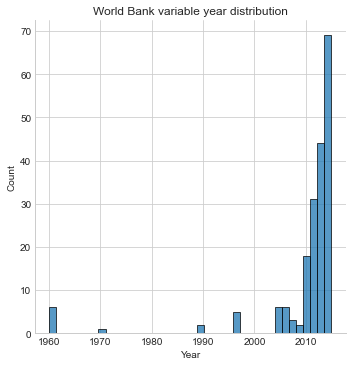

In [142]:
# Cleaning the data

# Inspecting the year element from our World Bank variable 
df_1 = pd.DataFrame(df.groupby(['country']).mean()['wb_year'])
ax = sns.displot(x='wb_year', data=df_1)
ax.set(title= "World Bank variable year distribution", xlabel= "Year")

In [116]:
# Aggregating the data

df_grouped_mean = df.groupby(['country']).mean()

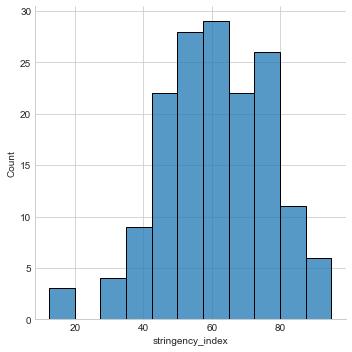

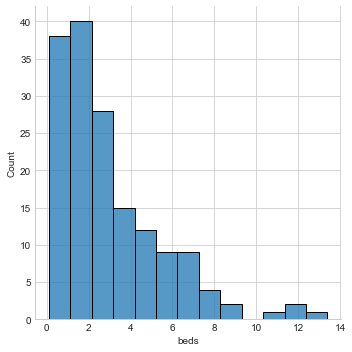

In [106]:
# Initial inspection of the data

sns.displot(x='stringency_index', data=df_grouped_mean)
sns.displot(x='beds', data=df_grouped_mean)

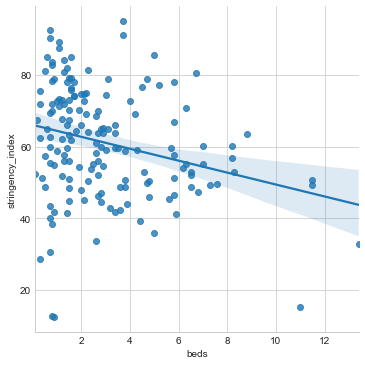

In [107]:
# Looking at the relationship

sns.lmplot('beds', 'stringency_index', data = df_grouped_mean)

## Part 1 - Discussion of results
*750 words*

# Part 2.

Develop a second research question that will require you to build in additional data (in less than 750 words). You will select an API (or direct URL) from the web which will allow you to download said data that you should merge in with the OxCOVID19 data. This second question does not need to be linked thematically to the first. Consider it like a second blog post. . You will first have to justify the choice of external data, your specific choice of API endpoints or URL, time frames or other ranges for this data. You should then report on the merged data through descriptive statistics and plots where appropriate. Data sources could include anything from reddit, Wikipedia, Facebook, Twitter, StackOverflow, or another source not covered in class (as long as it is publicly available either openly or through a free registered account). You can use external libraries (such as praw) in order to collect this data. Please do not submit any private API keys with this data. We suggest that private keys be written in an external file that is read by the notebook just to be safe. You should interpret the resulting output and summarise it in a report section of not more than 750 words.

It is not assumed that the evaluators will be able to reproduce this section with your code since it might involve the use of user-generated API keys or other forms of authentication not available to the evaluators. However, the section should include all relevant code and output other than the keys. You should consider an approach that does not require you to repeatedly request the same data from the API, such as writing it to file and then working on it in a different cell, or from the data you have now stored.

Example research questions for this section:

Do countries with longer Wikipedia pages also have more extensive government responses to COVID?
Comparing two countries, one with a high number of active cases and one with a low number: does the one with active cases have a higher proportion of tweets mentioning COVID in a window of time for Twitter streaming requests.
Which countries are mentioned most often in /r/coronavirus and do they relate to statistics concerning COVID
Examples of non-COVID research questions:

Do countries with longer Wikipedia pages (external) correlate with higher GDP (from the World Bank tables)?
Does a country’s democracy index (e.g., https://en.wikipedia.org/wiki/Democracy_Index) relate to more stable weather?
Finally, please write a reflective conclusion (of not more than 500 words) that discusses the limitations of the data in relation to your claims. You are also encouraged to build in any concerns about insights arising from this data, ethical issues with the analysis, and potential future avenues for analysis based on your work.

This work, while in a report style, should be referenced like any scholarly work. Please include a cell at the bottom of your notebook which includes all the references.

We request that you submit this summative as both a working Jupyter notebook (*.ipynb file) and as a PDF file that includes all of your output. This is because the evaluators may run your code and might still want to check this with the output that you have submitted. This pdf can either be generated from JupyterLab itself if you have the appropriate LaTeX modules installed or simply by going to ‘print’ for that browser window and print to PDF.   

## Part 2 - Setup

## Part 2 - Data Analysis in Python

## Part 2 - Discussion of Results
*750 words*

## Limitations
*One cell*

# Submission Instructions 

The assignment must be submitted electronically via the Assignment Submission WebLearn Site before midday on Monday 7th December (Week 9 Michaelmas Term).

If anything goes wrong with your submission, email msc@oii.ox.ac.uk immediately. In cases where a technical fault that is later determined to be a fault of the WebLearn system (and not a fault of your computer) prevents your submitting the assessment on time, having a time stamped email message will help the Proctors determine if your assessment will be accepted. Please note that you should not wait until the last minute to submit materials since WebLearn can run slowly at peak submission times and this is not considered a technical fault.

Full instructions on using WebLearn for electronic submissions can be found on Canvas.

Candidate Number and Cover Sheet: Remember to use the OII coversheet, stating clearly your candidate number, your course, assignment, title and word count. Your work should be identified ONLY by your candidate number (which can be found by visiting the online Student Self-Service facility).

Remember we are required under regulations to accept your FIRST submission so please make sure you are uploading the correct file.

### Ideas
* Do countries with lower hospital capacity impose stricter measures?
    * It would make sense that countries which have less capacity in their hospitals run a higher risk of getting overwhelmed by a rise of COVID cases, therefore they have less room to take risks by having looser restrictions.

* Bauer et al. find that "geographical access to intensive care beds varies significantly across European countries and low ICU accessibility was associated with a higher proportion of COVID-19 deaths to cases (CFR)". 

* Davies et al.: "These studies have broadly suggested that moderate measures could reduce epidemic size, but more intensive measures would be required to ensure health system capacity was not surpassed."

* Davies et al. " Intensive interventions with lockdown periods would need to be in place for a large proportion of the coming year to prevent health-care demand exceeding availability."

* Sebhatu et al: Countries with higher care capacity were slower to adopt COVID-19 restrictions.

* Sussman: "A smaller supply of hospital beds leads to higher mortality rates that induce governments to take more stringent closure measures that have greater economic costs. Higher mortality could also affect consumer confidence, bring about panic-driven decisions that also affect the economy adversely."

* Elgin: "This result implies that countries where the number of beds per capita is lower, more stringent economic stimulus is adopted."
